# Validation of the PyPSA-Earth Installed capacity

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [1]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


### Set main directory to root folder

In [2]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

from _helpers import three_2_two_digits_country, two_2_three_digits_country, country_name_2_two_digits

## 1. Load data 

#### IRENA data
Retrieved from [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).\
Please, download the statistics for 2020 for all the world and specify the url specified above, saving it to pypsa-earth-project/documentation, and changing the file name in the script to match the downloaded file.

In [72]:
year_select = 2020

IRENA_path = os.getcwd() + "/ELECSTAT_20240720-101428.csv" # change path to match downloaded file
df_irena = pd.read_csv(IRENA_path, skiprows=2, encoding="latin-1")
df_irena = df_irena[df_irena.loc[:, "Year"] == year_select]
df_irena["alpha2"] = df_irena.loc[:, "Country/area"].apply(
    lambda x: country_name_2_two_digits(x)
)
# electricity_demand_owid = df
# electricity_demand_owid.tail(2)

In [96]:
#rename congo and democratic republic of congo
df_irena.loc[df_irena["Country/area"] == "Republic of Congo", "Country/area"] = "Republic of Congo"
df_irena.loc[df_irena["Country/area"] == "Democratic Republic of the Congo (the)", "Country/area"] = "Congo, Democratic Republic of the"

In [104]:
# df_irena = df_irena[df_irena["Technology"] != "Total Renewable"]
# df_irena = df_irena[df_irena["Technology"] != "Total Non-Renewable"]


#### PyPSA generator data

Loads the PyPSA generators data

##### Load data from the network and create normalized dataframe

In [105]:
addelectricity_network_path = os.getcwd() + "/pypsa-earth/networks/eeap/elec.nc"
pypsa_network = pypsa.Network(addelectricity_network_path)

# statistics of non-storage units
installed_capacity_nostorages = pypsa_network.generators.copy()
# add country column
installed_capacity_nostorages["alpha2"] = installed_capacity_nostorages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["ror"]), "carrier"
] = "hydro"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "onshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["offwind-ac", "off-shore-dc"]),
    "carrier",
] = "offshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["CCGT", "OCGT"]), "carrier"
] = "gas"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "wind"
installed_capacity_nostorages_select = installed_capacity_nostorages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]

# statistics of storage units
installed_capacity_storages = pypsa_network.storage_units.copy()
# add country column
installed_capacity_storages["alpha2"] = installed_capacity_storages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_storages.loc[
    installed_capacity_storages["carrier"] == "PHS", "carrier"
] = "hydro"
installed_capacity_storages_select = installed_capacity_storages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]


installed_capacity_raw = pd.concat(
    [installed_capacity_storages_select, installed_capacity_nostorages_select]
)
installed_capacity = installed_capacity_raw.groupby(["alpha2", "carrier"])[
    "p_nom"
].sum()
installed_capacity.groupby("carrier").sum()

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas.

carrier
biomass            614.000000
csp                  0.000000
gas              67689.237308
geothermal        1092.000000
hydro            27382.304599
nuclear           1194.000000
offshore wind        0.000000
offwind-dc           0.000000
oil              15075.442969
onshore wind      2037.386411
solar             2071.205388
Name: p_nom, dtype: float64

##### Load PyPSA powerplant data to crosscheck data from the network

In [107]:
powerplants_data = os.getcwd() + "/pypsa-earth/resources/eeap/powerplants.csv"
available_generators = pd.read_csv(powerplants_data)
installed_capacity_resources = available_generators.groupby(["Country", "Fueltype"])[
    "Capacity"
].sum()
installed_capacity_resources.groupby(["Fueltype"]).sum()

Fueltype
Bioenergy       614.000000
CCGT          67689.237308
Geothermal     1092.000000
Hydro         27562.304599
Nuclear        1194.000000
Oil           15075.442969
Waste            24.508994
Name: Capacity, dtype: float64

# 2. Validate

#### Steps:
- Specify year of interest of the IRENA dataset and the countries of interest
- Harmonize IRENA dataset to the PyPSA standard
- Align dataframe naming and temporal resolution
- Merge dataframe


##### Specify year of the analysis and the countries of interest

In [109]:
year_owid = 2020  # option
country_list = installed_capacity_nostorages.alpha2.unique()
country_list

array(['KE', 'LY', 'EG', 'RW', 'TZ', 'SD', 'ET', 'UG', 'DJ', 'CD', 'BI',
       'SS', 'SO'], dtype=object)

##### Process IRENA data to match PyPSA standard

In [116]:
# copy IRENA dataset
df = df_irena.copy()

# Process technologies
df.loc[
    df["Technology"].isin(["Solar photovoltaic", "Solar thermal energy"]), "Technology"
] = "solar"
df.loc[df["Technology"].isin(["Onshore wind energy"]), "Technology"] = "onshore wind"
df.loc[df["Technology"].isin(["Offshore wind energy"]), "Technology"] = "offshore wind"
df.loc[
    df["Technology"].isin(
        ["Renewable hydropower", "Mixed Hydro Plants", "Pumped storage"]
    ),
    "Technology",
] = "hydro"
df.loc[
    df["Technology"].isin(["Other non-renewable energy", "Marine energy"]), "Technology"
] = "other"
df.loc[
    df["Technology"].isin(["Liquid biofuels", "Biogas", "Solid biofuels"]), "Technology"
] = "bioenergy"
df.loc[df["Technology"].isin(["Geothermal energy"]), "Technology"] = "geothermal"
df.loc[df["Technology"].isin(["Natural gas"]), "Technology"] = "gas"
df.loc[df["Technology"].isin(["Renewable municipal waste"]), "Technology"] = "waste"
df.loc[df["Technology"].isin(["Coal and peat"]), "Technology"] = "coal"
df.loc[df["Technology"].isin(["Oil", "Fossil fuels n.e.s."]), "Technology"] = "oil"


df = df[df.alpha2.isin(country_list)]
df["p_nom"] = pd.to_numeric(
    df["Electricity statistics (MW/GWh)"], errors="coerce"
)
installed_capacity_irena = (
    df.rename(columns={"Technology": "carrier"})
    .groupby(["alpha2", "carrier"])["p_nom"]
    .sum()
)
# installed_capacity_irena.groupby("carrier").sum()

##### Merge datasets by carrier

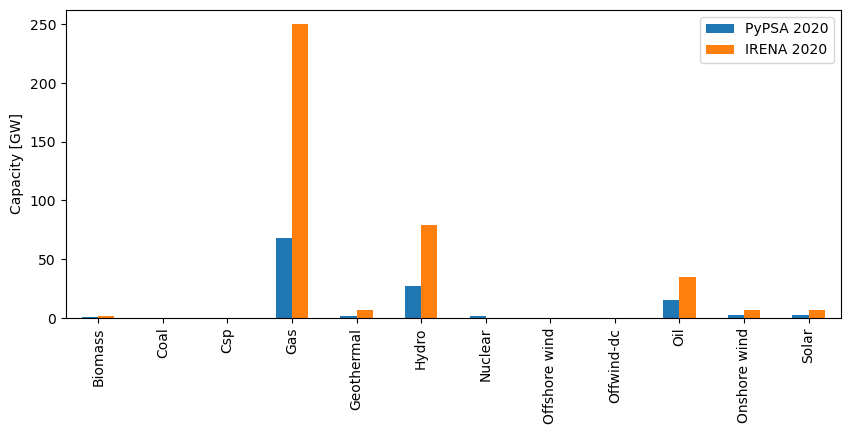

In [120]:
world_ic = installed_capacity_irena.groupby("carrier").sum() / 1000
world_ic = world_ic.rename(index={"bioenergy": "Biomass"})

world_ic.index = world_ic.index.str.capitalize()

world_pypsa = installed_capacity.groupby("carrier").sum() / 1000
if "load" in world_pypsa.index:
    world_pypsa = world_pypsa.drop("load")
world_pypsa.index = world_pypsa.index.str.capitalize()

world_compare = pd.concat(
    [world_pypsa.rename("PyPSA 2020"), world_ic.rename("IRENA 2020")], axis=1
)

# Sorting and dropping
world_compare = world_compare.drop("Waste")
world_compare = world_compare.drop("Other")
world_compare = world_compare.sort_index()

# Plot
ax = world_compare.plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

# plt.savefig("capacity-validation-all.pdf", bbox_inches="tight")

[Text(0.5, 0, '')]

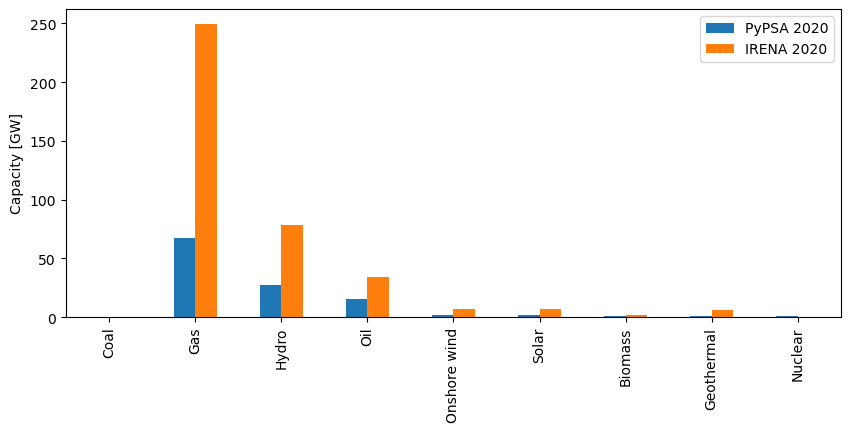

In [123]:
list_carriers = [
    "Coal",
    "Gas",
    "Hydro",
    "Oil",
    "Onshore wind",
    "Solar",
    "Biomass",
    "Geothermal",
    "Nuclear",
]

world_compare.loc[list_carriers].plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

# plt.savefig("capacity-validation.pdf", bbox_inches="tight")

##### Merge dataframes by technology for specific country

##### Merge dataframes by country

[Text(0.5, 0, '')]

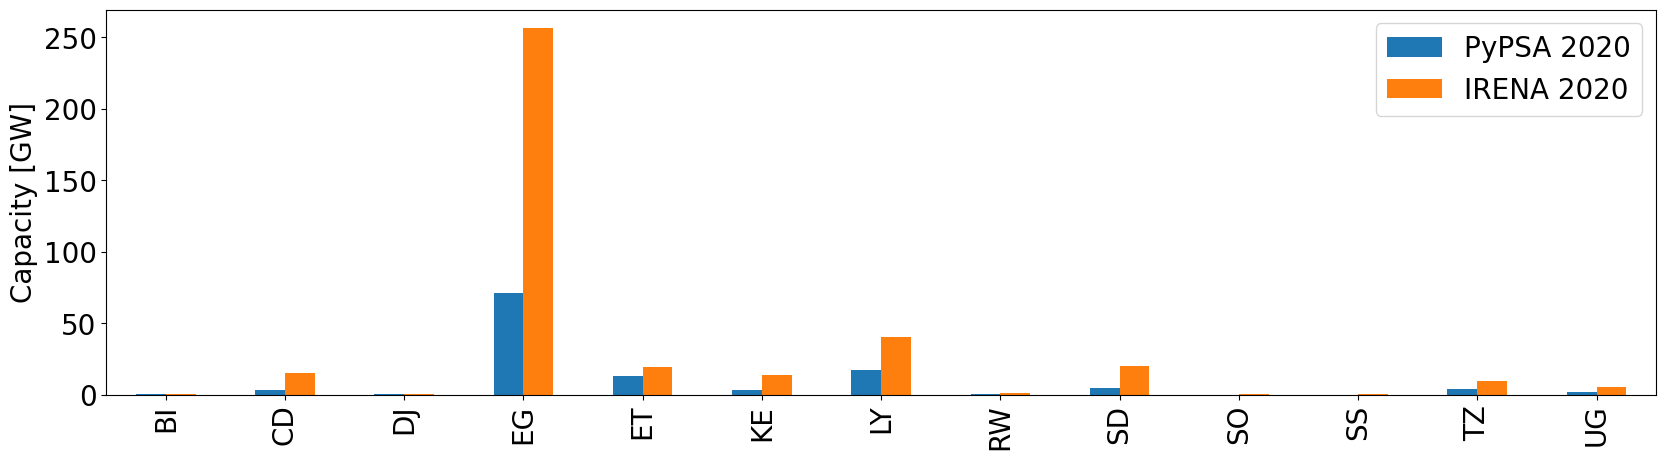

In [125]:
country_ic = (
    installed_capacity_irena[
        installed_capacity_irena.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)
country_pypsa = (
    installed_capacity[
        installed_capacity.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)

country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = pd.Series(
    country_compare.index.map(country_name_2_two_digits)
).replace(
    {
        "Congo, The Democratic Republic of the": "DRC",
        "Central African Republic": "CAR",
        "Tanzania, United Republic of": "Tanzania",
    }
)
plt.rcParams.update({"font.size": 20})
ax = country_compare.plot.bar(
    figsize=(20, 5), ylabel="Capacity [GW]", xlabel="Country", fontsize=20
)
ax.set(xlabel=None)

# plt.savefig("capacity-validation-by-country.pdf", bbox_inches="tight")